# Description of the project

It is necessary to decide where to drill a new well. The steps for choosing a location are usually as follows:

- Characteristics for wells are collected in the selected region: oil quality and volume of its reserves;
- Build a model to predict the volume of reserves in new wells;
- Choose the wells with the highest value estimates;
- Determine the region with the maximum total profit of the selected wells.

There are oil samples in three regions. The characteristics for each well in the region are already known. It is necessary to build a model to determine the region where mining will bring the greatest profit by analyzing the possible profit and risks using the Bootstrap technique.

## Conditions of the problem

- Only linear regression is suitable for training the model (the rest are not predictable enough).
- When exploring a region, 500 points are explored, from which the best 200 are selected for profit calculation.
- The budget for the development of wells in the region is 10 billion rubles.
- One barrel of raw materials brings 450 rubles of income. The income from each unit of the product is 450 thousand rubles, since the volume is indicated in thousands of barrels.
- After assessing the risks, you need to leave only those regions in which the probability of losses is less than 2.5%. Among them, choose the region with the highest average profit.

Synthetic data: details of contracts and characteristics of deposits were not disclosed.

# Description of data

Geological exploration data of three regions are in the files:

- `geo_data_0.csv`;
- `geo_data_1.csv`;
- `geo_data_2.csv`;
- `id` — unique identifier of the well;
- `f0`, `f1`, `f2` - three signs of dots (it doesn't matter what they mean, but the signs themselves are significant);
- `product` — volume of reserves in the well (thousand barrels).

# Action plan

1. Download and prepare data
2. Train and test the model for each region: <br />
    2.1. Split the data into training and validation samples in a ratio of 75:25. <br />
    2.2. Train the model and make predictions on the validation set. <br />
    2.3. Store predictions and correct answers on the validation set. <br />
    2.4. Print on the screen the average stock of the predicted raw material and the RMSE of the model. <br />
    2.5. Analyze results. <br />
3. Prepare for profit calculation: <br />
    3.1. Save all key values ​​for calculations in separate variables. <br />
    3.2. Calculate a sufficient volume of raw materials for the break-even development of a new well. Compare the received volume of raw materials with the average stock in each region. <br />
    3.3. Write conclusions on the stage of preparing the calculation of profit. <br />
4. Write a function to calculate profit for selected wells and model predictions: <br />
    4.1. Select wells with maximum prediction values. The number of wells depends on the company's budget and the cost of developing one well. <br />
    4.2. Sum the target value of the volume of raw materials corresponding to these predictions. <br />
    4.3. Calculate the profit for the received volume of raw materials. <br />
5. Calculate risks and profits for each region: <br />
    5.1. Apply the Bootstrap technique with 1000 samples to find the profit distribution. <br />
    5.2. Find the average profit, 95% confidence interval and risk of loss. Loss is negative profit. <br />
    5.3. Write conclusions: suggest a region for well development and justify the choice. <br />

# Import data files, study general information

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import display


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from scipy import stats as st

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [2]:
PATH = "/datasets"
files = ['geo_data_0.csv', 'geo_data_1.csv', 'geo_data_2.csv']
q = range(len(files))
dfs = []

for file in files:
    with open(os.path.join(PATH, file)) as f:
        dfs.append(pd.read_csv(f, sep=','))

for df in dfs:
    
    display(df)
    df.info()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...,...
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
...,...,...,...,...,...
99995,QywKC,9.535637,-6.878139,1.998296,53.906522
99996,ptvty,-10.160631,-12.558096,5.005581,137.945408
99997,09gWa,-7.378891,-3.084104,4.998651,137.945408
99998,rqwUm,0.665714,-6.152593,1.000146,30.132364


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
...,...,...,...,...,...
99995,4GxBu,-1.777037,1.125220,6.263374,172.327046
99996,YKFjq,-1.261523,-0.894828,2.524545,138.748846
99997,tKPY3,-1.199934,-2.957637,5.219411,157.080080
99998,nmxp2,-2.419896,2.417221,-5.548444,51.795253


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


# Data preparation

Get rid of unnecessary features

In [3]:
for i in q: dfs[i] = dfs[i].drop(['id'], axis=1)

Divide the samples into sets with features and a target feature

In [4]:
features = []
target = []

for i in q:
    
    features.append(dfs[i].drop(['product'], axis=1))
    target.append(dfs[i]['product'])

Let's split the data into two samples: train, validation `3 : 1`

In [5]:
features_train = []
features_valid = []
target_train = []
target_valid = []

for i in q:
    a, b = train_test_split(features[i], test_size=0.25, random_state=12345)
    features_train.append(a)
    features_valid.append(b)
    
    a, b = train_test_split(target[i], test_size=0.25, random_state=12345)
    target_train.append(a)
    target_valid.append(b)
    
    print(features[i].shape)
    print(features_train[i].shape)
    print(features_valid[i].shape)
    print(target_train[i].shape)
    print(target_valid[i].shape)
    print()

(100000, 3)
(75000, 3)
(25000, 3)
(75000,)
(25000,)

(100000, 3)
(75000, 3)
(25000, 3)
(75000,)
(25000,)

(100000, 3)
(75000, 3)
(25000, 3)
(75000,)
(25000,)



Scale features

In [6]:
numeric = ['f0', 'f1', 'f2']

for i in q:
    scaler = StandardScaler()
    scaler.fit(features_train[i].loc[:, numeric])
    features_train[i].loc[:, numeric] = scaler.transform(features_train[i].loc[:, numeric])
    features_valid[i].loc[:, numeric] = scaler.transform(features_valid[i].loc[:, numeric])
    features[i].loc[:, numeric] = scaler.transform(features[i].loc[:, numeric])

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/opt/conda/lib/py

# Train and validate the model

In [7]:
predicted_valid = []
predicted = []

for i in q:  
    model = LinearRegression()
    model.fit(features_train[i], target_train[i])

    predicted_valid.append(model.predict(features_valid[i]))
    predicted_valid[i] = pd.Series(predicted_valid[i], index=target_valid[i].index) 

    predicted.append(model.predict(features[i]))
    predicted[i] = pd.Series(predicted[i], index=target[i].index) 
    
    rmse = mean_squared_error(target[i], predicted[i]) ** 0.5
    
    print('The average stock of the predicted raw materials of the region', i, '(in thousand bar):', '{:,.2f}'.format(predicted[i].mean()))
    print('RMSE (in thousand bar):', rmse)
    print()

Средний запас предсказанного сырья региона 0 (в тыс. бар.): 92.63
RMSE (в тыс. бар.): 37.69240596744535

Средний запас предсказанного сырья региона 1 (в тыс. бар.): 68.83
RMSE (в тыс. бар.): 0.8903802650297561

Средний запас предсказанного сырья региона 2 (в тыс. бар.): 95.02
RMSE (в тыс. бар.): 40.055624818752136



## Conclusion:

The RMSE of the model is quite high, but this is not an indicator. To draw any conclusions, it is also necessary to use other metrics.

# Calculation of the volume of raw materials for break-even development of a new well

In [8]:
POINTS = 500 # number of studied points
BEST_POINTS = 200 # number of best spots
BUDGET = 10e9 # well development budget, rub.
BUDGET_PER_POINT = BUDGET / BEST_POINTS
BAR_PRICE = 450000 # price per 1 thousand bar.
VOLUME = BUDGET_PER_POINT / BAR_PRICE

print('Required volume for break-even development of a new well, in thousand bar:', '{:,.2f}'.format(VOLUME))

for i in q: print('Average stock in the region', i, '(in thousand bar):', '{:,.2f}'.format(predicted[i].mean()))

Необходимый объем для безубыточной разработки новой скважины, тыс. бар.: 111.11
Средний запас в регионе 0 (в тыс. бар.): 92.63
Средний запас в регионе 1 (в тыс. бар.): 68.83
Средний запас в регионе 2 (в тыс. бар.): 95.02


## Conclusion

Comparison of the average reserves in the regions with the break-even required volume at first glance shows that there are not enough oil reserves in the selected regions. However, this view may be misleading, as the mean is easily outlier and each case must be studied in detail.

# Function to calculate profit for selected wells and model predictions|

In [9]:
def revenue(subsample, target):
    index = subsample.sort_values(ascending=False).head(BEST_POINTS).index
    return target[index].sum() * BAR_PRICE - BUDGET_PER_POINT * BEST_POINTS

# Calculation of risks and rewards for each region

Средняя прибыль региона 0 (руб.) 424,149,751.40
95% доверительый интервал (руб.): от -77,856,923.73 до 968,580,699.60
Риск убытков (%): 5.20



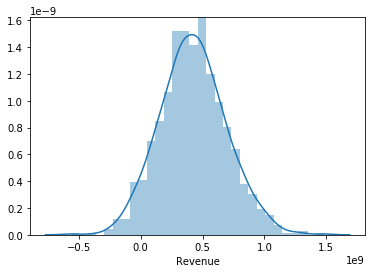

Средняя прибыль региона 1 (руб.) 448,720,640.03
95% доверительый интервал (руб.): от 37,498,074.53 до 823,829,920.21
Риск убытков (%): 1.40



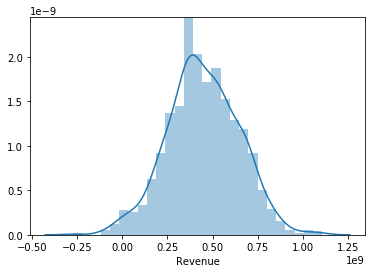

Средняя прибыль региона 2 (руб.) 373,939,021.99
95% доверительый интервал (руб.): от -181,948,188.45 до 896,299,408.10
Риск убытков (%): 9.20



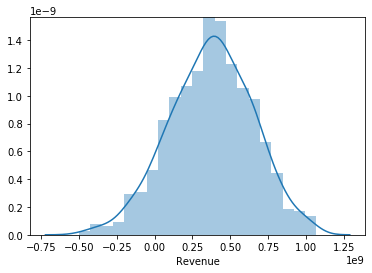

In [10]:
for i in q:
    state = np.random.RandomState(12345)
    values = []
    for j in range(1000):

        subsample = predicted[i].sample(n=POINTS, replace=True, random_state=state)
        values.append(revenue(subsample, target[i]))

    values = pd.Series(values)

    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    mean_value = values.mean()
    risk = (values[values < 0].count() / values.count()) * 100

    print('Average profit of the region', i, '(rub.)', '{:,.2f}'.format(mean_value))
    print('95% confidence interval (rub.): от','{:,.2f}'.format(lower),'до', '{:,.2f}'.format(upper))
    print('Риск убытков (%):','{:.2f}'.format(risk))
    print()
    sns.distplot(values, kde=True)
    plt.xlabel('Revenue')
    plt.show()

## Conclusion

As a development region, I suggest choosing `"region 1"`, because:
  - The 2.5% quantile of this region has the largest value, which differs many times from other regions
  - the risk of loss is minimal
  - average value of profit - the largest of the presented
 
That is, with a 95% probability we can say that the profit will be at least more than 37 million rubles.

In [16]:
values = ['a', 'b', 'c', 'd', 'e']
values = pd.Series(values)
state = np.random.RandomState(12345)
for i in range(5):
    
    subsample = values.sample(n=2, replace=True, random_state=12345)
    print(state)
    print(subsample)
    print()

RandomState(MT19937)
2    c
1    b
dtype: object

RandomState(MT19937)
2    c
1    b
dtype: object

RandomState(MT19937)
2    c
1    b
dtype: object

RandomState(MT19937)
2    c
1    b
dtype: object

RandomState(MT19937)
2    c
1    b
dtype: object

